### note: implement dice as a callback

### imports

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
from fastai.vision.interpret import *
from losses import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [4]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/tmp'),
 PosixPath('../../data/siim_acr_pneu/preds'),
 PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [5]:
torch.cuda.set_device(2)

In [6]:
chx_mimic_stats = [tensor([0.485, 0.456, 0.406]), tensor([0.229, 0.224, 0.225])]

### databunch

In [7]:
bs,sz = 8,224
fold_idx = 0 # for kfold
tfms = get_transforms()

In [8]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)

In [9]:
get_y_fn = lambda x: data_path/f'train/masks_{sz}/{Path(x).stem}.png'
codes = ['void', 'pthorax']

In [10]:
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

In [11]:
items = (SegmentationItemList.from_csv(data_path, 'seg_df.csv', folder=f'train/images_{sz}', suffix='.jpg'))
trn_idxs, val_idxs = list(kfold.split(range(len(items))))[fold_idx]
data = (items.split_by_idxs(trn_idxs, val_idxs)
        .label_from_func(get_y_fn, classes=codes)
        .transform(tfms=tfms, size=sz, tfm_y=True, resize_method=ResizeMethod.NO, padding_mode='reflection')
        .databunch(bs=bs)
        .normalize(chx_mimic_stats))

In [12]:
data

ImageDataBunch;

Train: LabelList (1903 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../../data/siim_acr_pneu;

Valid: LabelList (476 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ../../data/siim_acr_pneu;

Test: None

In [13]:
# data.show_batch()

### model

In [14]:
# from fastai.train import BnFreeze
# from unet import unet_learner #custom unet_learner

# def xresnet50(pretrained=True):
#     return models.xresnet50(pretrained=pretrained)

# def xresnet34(pretrained=True):
#     return models.xresnet34(pretrained=pretrained)

In [27]:
from fastai.callbacks.hooks import model_sizes

body = create_body(models.densenet121)
chx_state_dict = torch.load("/home/turgutluk/data/models/chx-mimic-only-pneumo-densenet121-320.pth")
for n, p in list(body.named_parameters()): p.data = chx_state_dict['0.' + n]
body = body[0].cpu()    

In [28]:
model_sizes(body)

[torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 32, 32]),
 torch.Size([1, 64, 16, 16]),
 torch.Size([1, 256, 16, 16]),
 torch.Size([1, 128, 8, 8]),
 torch.Size([1, 512, 8, 8]),
 torch.Size([1, 256, 4, 4]),
 torch.Size([1, 1024, 4, 4]),
 torch.Size([1, 512, 2, 2]),
 torch.Size([1, 1024, 2, 2]),
 torch.Size([1, 1024, 2, 2])]

In [29]:
densenet_children = list(body.children())
unet_densenet_body = nn.Sequential(nn.Sequential(*densenet_children[:3]),
                                   nn.Sequential(*densenet_children[3:5]),
                                   nn.Sequential(*densenet_children[5:7]),
                                   nn.Sequential(*densenet_children[7:9]),
                                   nn.Sequential(*densenet_children[9:]))

In [30]:
model_sizes(unet_densenet_body)

[torch.Size([1, 64, 32, 32]),
 torch.Size([1, 256, 16, 16]),
 torch.Size([1, 512, 8, 8]),
 torch.Size([1, 1024, 4, 4]),
 torch.Size([1, 1024, 2, 2])]

In [31]:
def _new_densenet_split(m:nn.Module): return (m[1])

In [32]:
try:size = data.train_ds[0][0].size
except: size = next(iter(data.train_dl))[0].shape[-2:]
model = to_device(models.unet.DynamicUnet(unet_densenet_body, n_classes=data.c, img_size=size), data.device)
learn = Learner(data, model)
learn.split(_new_densenet_split)
apply_init(learn.model[1:], nn.init.kaiming_normal_)

In [54]:
# MONKEY PATCH: Remove print statement at every improvement
from fastai.callbacks import SaveModelCallback
def _on_epoch_end(self, epoch:int, **kwargs:Any)->None:
    "Compare the value monitored to its best score and maybe save the model."
    if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
    else: #every="improvement"
        current = self.get_monitor_value()
        if current is not None and self.operator(current, self.best):
            self.best = current
            self.learn.save(f'{self.name}')
            
SaveModelCallback.on_epoch_end = _on_epoch_end
learn.callbacks.append(SaveModelCallback(learn, monitor='dice', name=f"seg-densenet121-{sz}-{fold_idx}"))

In [55]:
learn.to_fp16()
learn.freeze() 
learn.loss_func = dice_loss
learn.metrics = [dice]

In [56]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
lr = 1e-4
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,dice,time
0,0.948263,0.948712,0.102478,02:16
1,0.939609,0.945779,0.119275,02:14
2,0.942249,0.944523,0.149000,02:16
3,0.939743,0.943909,0.140165,02:16


In [ ]:
learn.unfreeze()

In [ ]:
lr /= 2
learn.fit_one_cycle(10, slice(lr), moms=(0.8,0.7))

In [ ]:
learn.to_fp32();

### add test

In [ ]:
test = ImageList.from_folder(data_path/f'test/images_{sz}', extensions='.jpg')

In [ ]:
learn.data.add_test(test, tfm_y=False)

In [ ]:
# learn.load(f"seg-resnet34-{sz}");
# learn.load(f"seg-chexpert-ft-resnet34-{sz}");
learn.load(f"seg-chexpert-ft-resnext34-{sz}-{fold_idx}");

In [192]:
learn.validate()

[0.44885084, tensor(0.5512)]

### save all learn obj

In [193]:
os.makedirs(data_path/"learn", exist_ok=True)

In [194]:
with ModelOnCPU(learn.model) as model:
    try_save({"data":learn.data, "model":model}, data_path, f"learn/seg-chexpert-ft-resnext34-{sz}-{fold_idx}")

In [195]:
f"learn/seg-chexpert-ft-resnext34-{sz}-{fold_idx}"

'learn/seg-chexpert-ft-resnext34-448-4'

### interpret

In [57]:
interp = SegmentationInterpretation.from_learner(learn=learn)

In [58]:
top_losses, top_idxs = interp.top_losses((sz,sz))

In [59]:
top_losses.shape, top_idxs.shape

(torch.Size([476]), torch.Size([476]))

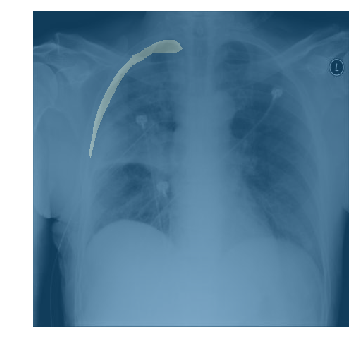

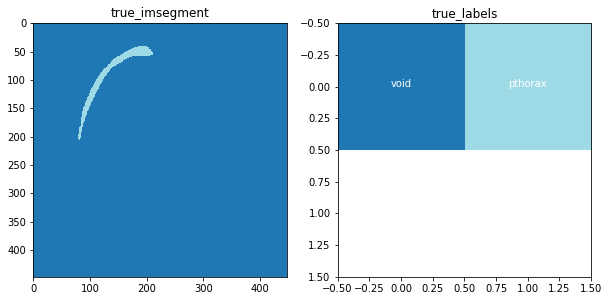

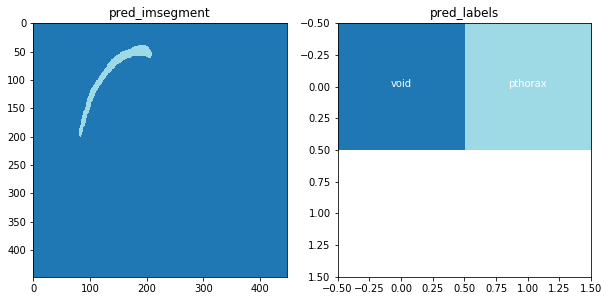

In [60]:
interp.show_xyz(np.random.choice(top_idxs))